In [1]:
import matplotlib
import requests
import json
import pylab
import io
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from astropy.io.votable import parse,parse_single_table,from_table, writeto
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
'''
rutas
http://3.212.59.238:8787/radio-degree
http://3.212.59.238:8787/radio-degree-nearest # entrega un solo objeto en caso de encontrar
http://3.212.59.238:8787/radio-hms
http://3.212.59.238:8787/radio-hms-nearest # entrega un solo objeto en caso de encontrar
'''

'\nrutas\nhttp://3.212.59.238:8787/radio-degree\nhttp://3.212.59.238:8787/radio-degree-nearest # entrega un solo objeto en caso de encontrar\nhttp://3.212.59.238:8787/radio-hms\nhttp://3.212.59.238:8787/radio-hms-nearest # entrega un solo objeto en caso de encontrar\n'

In [62]:
def consulta_degree(ra,dec,radius,format,catalog):
    url = 'http://127.0.0.1:5000/radio-degree-nearest'
    params = {'ra':ra,'dec':dec,'radius':radius,'format':format,'catalog':catalog}
    r = requests.post(url, data=params)
    return r

In [4]:
def consulta_hms(hms,radius,format,catalog):
    url = 'http://127.0.0.1:5000/radio-hms'
    params = {'hms':hms,'radius':radius,'format':format,'catalog':catalog}
    r = requests.post(url, data=params)
    return r

In [63]:
#consulta por grados
rdg = consulta_degree(139.33444972,68.6350604,0.0002777,'json','ztf')

In [45]:
#consulta a ps1
rdg_ps1 = consulta_degree(139.33444972,68.6350604,0.0002777,'json','ps1')

In [56]:
rdg

<Response [200]>

In [64]:
# clave de catalogos consultados
catalog = rdg.json().keys()
catalog

dict_keys(['curve_ztf'])

In [65]:
#claves de los elementos en X catalogo
rdg.json()['curve_ztf'].keys()

dict_keys(['1848215200006181'])

In [66]:
rdg.json()['curve_ztf']

{'1848215200006181': '{"oid":{"0":1848215200006181,"1":1848215200006181,"2":1848215200006181,"3":1848215200006181,"4":1848215200006181,"5":1848215200006181,"6":1848215200006181,"7":1848215200006181,"8":1848215200006181,"9":1848215200006181,"10":1848215200006181,"11":1848215200006181,"12":1848215200006181,"13":1848215200006181,"14":1848215200006181},"expid":{"0":68534672,"1":68834674,"2":69445563,"3":69542348,"4":72243163,"5":72745324,"6":78037050,"7":78622905,"8":80419596,"9":82023686,"10":82824655,"11":83520562,"12":83828582,"13":83932565,"14":86426273},"hjd":{"0":2458439.8487261995,"1":2458442.848916023,"2":2458448.9581267601,"3":2458449.9260226064,"4":2458476.9352070414,"5":2458481.956929598,"6":2458534.8736852934,"7":2458540.7319906708,"8":2458558.6980075249,"9":2458574.7379578715,"10":2458582.7471384467,"11":2458589.7057655635,"12":2458592.7857643533,"13":2458593.825535519,"14":2458618.7610815731},"mjd":{"0":58439.3467245,"1":58442.3467477,"2":58448.4556366,"3":58449.4234838,"4":5

In [46]:
rdg_ps1.json()['curve_ps1']

{'190361393344112894': {'data': [['190361393344112894',
    '153443866410000015',
    3,
    55635.4389349,
    139.33447819,
    68.63506142,
    0.008843869902193546,
    1.0087999726238195e-05,
    1.548509955406189,
    1.4958100318908691,
    0.9047060012817383,
    0.008679470047354698,
    1.0326800293114502e-05,
    '102760517',
    128,
    7374912],
   ['190361393344112894',
    '153445192410000017',
    3,
    55635.4521903,
    139.33449752,
    68.63506221,
    0.008280499838292599,
    1.0222100172541104e-05,
    1.9910399913787842,
    1.956779956817627,
    0.9989989995956421,
    0.00838323961943388,
    1.0059299711429048e-05,
    '102760517',
    128,
    7374912],
   ['190361393344112894',
    '153347716310000010',
    1,
    55634.477414,
    139.3345207,
    68.63503577,
    0.00826191995292902,
    1.1407400052121375e-05,
    1.881850004196167,
    1.7673399448394775,
    0.9929159879684448,
    0.008617050014436245,
    1.1423299838497769e-05,
    '102760517',
 

In [7]:
#consulta hours
#hms_tuple(h=9.0, m=17.0, s=20.26793280000689)
#hms_tuple(h=4.0, m=34.0, s=32.414496000003936)
#'9h17m20.26793280000689s + 4h34m32.414496000003936s'

rhms = consulta_hms('9h17m20.26793280000689s +4h34m32.414496000003936s',0.0002777,'votable','ztf,ps1' )
#rhrs.text

In [8]:
catalog_hms = rhms.json().keys()
catalog_hms

dict_keys(['curve_ps1', 'curve_ztf'])

In [10]:
rhms.json()['curve_ztf']['1848215200006181']

'<?xml version="1.0" encoding="utf-8"?>\n<!-- Produced with astropy.io.votable version 4.0.1.post1\n     http://www.astropy.org/ -->\n<VOTABLE version="1.4" xmlns="http://www.ivoa.net/xml/VOTable/v1.4" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://www.ivoa.net/xml/VOTable/v1.4">\n <RESOURCE type="results">\n  <TABLE>\n   <FIELD ID="oid" datatype="long" name="oid" ucd="meta.id">\n    <DESCRIPTION>\n     Object ID\n    </DESCRIPTION>\n   </FIELD>\n   <FIELD ID="expid" datatype="int" name="expid" ucd="meta.id;obs.exposure">\n    <DESCRIPTION>\n     Exposure ID\n    </DESCRIPTION>\n   </FIELD>\n   <FIELD ID="hjd" datatype="double" name="hjd" ucd="time.epoch" unit="d">\n    <DESCRIPTION>\n     Heliocentric Julian date (computed from mjd and the mean ra and\n     dec of the input catalog)\n    </DESCRIPTION>\n   </FIELD>\n   <FIELD ID="mjd" datatype="double" name="mjd" ucd="time.epoch;obs.exposure" unit="d">\n    <DESCRIPTION>\n     Modified Juli

In [42]:
# devuelve la tabla de astropy (para procesesar)en caso de recibir un VOTable
votable = rhms.json()['curve_ztf']['1848215200006181'].encode(encoding='UTF-8')
bio = io.BytesIO(votable)
table = parse_single_table(bio).to_table()
table

oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,chi,sharp,filefracday,field,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
,,d,d,mag,mag,,,deg,deg,,,,,,,mag,mag,mag,,,s,,
int64,int32,float64,float64,float32,float32,int32,object,float64,float64,float32,float32,int64,int32,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,int32
1848215200006181,68534672,2458439.8487261995,58439.3467245,14.812388,0.010627259,0,zr,139.3344517,68.6350696,1.251,0.025,20181117346725,1848,15,2,21.07,25.934923,0.029220562,0.09071297,2.4725716e-05,30.0,1.782,2
1848215200006181,68834674,2458442.848916023,58442.3467477,14.68032,0.010582386,32768,zr,139.3344459,68.6350708,0.438,-0.005,20181120346713,1848,15,2,19.48,25.443281,0.07455926,0.08373893,0.00018429228,30.0,1.727,2
1848215200006181,69445563,2458448.95812676,58448.4556366,14.564754,0.010563088,0,zr,139.3344546,68.6350707,0.833,0.0,20181126455602,1848,15,2,20.39,26.127449,0.029332612,0.091096,2.5088662e-05,30.0,1.247,2
1848215200006181,69542348,2458449.9260226064,58449.4234838,14.566062,0.010563211,0,zr,139.3344296,68.6350623,0.767,0.049,20181127423484,1848,15,2,20.78,26.142992,0.024987929,0.091695316,1.8074616e-05,30.0,1.312,2
1848215200006181,72243163,2458476.9352070414,58476.4316319,14.111308,0.010633541,0,zr,139.3344171,68.6350685,0.572,0.027,20181224431632,1848,15,2,20.62,26.128452,0.02624794,0.08898855,1.9773155e-05,30.0,1.181,2
1848215200006181,72745324,2458481.956929598,58481.4532407,14.360865,0.010568685,0,zr,139.3343829,68.6350885,0.871,-0.007,20181229453241,1848,15,2,20.53,26.13246,0.028952507,0.09266664,2.4481273e-05,30.0,1.169,2
1848215200006181,78037050,2458534.8736852934,58534.3705093,13.895456,0.010731635,0,zr,139.3345263,68.6352901,1.509,0.021,20190220370451,1848,15,2,18.97,26.112165,0.045237727,0.10235295,9.374093e-05,30.0,1.22,1
1848215200006181,78622905,2458540.731990671,58540.2290509,13.990696,0.0106840795,0,zr,139.334429,68.6350604,0.85,0.026,20190226229051,1848,15,2,21.59,26.117912,0.026266078,0.09380243,1.9790385e-05,30.0,1.221,1


In [36]:
# devuelve la tabla de astropy, en caso de recivir un csv
tabla = ascii.read(rdg.json()['curve_ztf']['1848215200006181'],  format='csv', guess=False)
tabla

oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,chi,sharp,filefracday,field,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
int64,int64,float64,float64,float64,float64,int64,str2,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64
1848215200006181,68534672,2458439.8487261995,58439.3467245,14.8123884,0.0106272586,0,zr,139.3344517,68.6350696,1.25100005,0.0250000004,20181117346725,1848,15.0,2.0,21.0699997,25.9349232,0.0292205624,0.090712972,2.47257158e-05,30,1.78199995,2
1848215200006181,68834674,2458442.848916023,58442.3467477,14.6803198,0.0105823856,32768,zr,139.3344459,68.6350708,0.437999994,-0.00499999989,20181120346713,1848,15.0,2.0,19.4799995,25.4432812,0.0745592564,0.0837389305,0.000184292279,30,1.727,2
1848215200006181,69445563,2458448.95812676,58448.4556366,14.5647535,0.0105630876,0,zr,139.3344546,68.6350707,0.833000004,0.0,20181126455602,1848,15.0,2.0,20.3899994,26.127449,0.0293326117,0.0910959989,2.50886624e-05,30,1.24699998,2
1848215200006181,69542348,2458449.9260226064,58449.4234838,14.566062,0.0105632106,0,zr,139.3344296,68.6350623,0.76700002,0.0489999987,20181127423484,1848,15.0,2.0,20.7800007,26.142992,0.0249879286,0.0916953161,1.80746156e-05,30,1.31200004,2
1848215200006181,72243163,2458476.9352070414,58476.4316319,14.1113081,0.0106335413,0,zr,139.3344171,68.6350685,0.572000027,0.0270000007,20181224431632,1848,15.0,2.0,20.6200008,26.1284523,0.0262479391,0.08898855,1.97731551e-05,30,1.18099999,2
1848215200006181,72745324,2458481.956929598,58481.4532407,14.3608646,0.0105686849,0,zr,139.3343829,68.6350885,0.870999992,-0.00700000022,20181229453241,1848,15.0,2.0,20.5300007,26.1324596,0.0289525073,0.0926666409,2.44812727e-05,30,1.16900003,2
1848215200006181,78037050,2458534.8736852934,58534.3705093,13.8954563,0.0107316347,0,zr,139.3345263,68.6352901,1.50899994,0.0209999997,20190220370451,1848,15.0,2.0,18.9699993,26.1121655,0.0452377275,0.102352947,9.37409277e-05,30,1.22000003,1
1848215200006181,78622905,2458540.731990671,58540.2290509,13.990696,0.0106840795,0,zr,139.334429,68.6350604,0.850000024,0.0260000005,20190226229051,1848,15.0,2.0,21.5900002,26.1179123,0.0262660775,0.0938024297,1.97903846e-05,30,1.22099996,1
1848215200006181,80419596,2458558.698007525,58558.1959606,13.8278322,0.0107691614,0,zr,139.3344451,68.6351031,1.44200003,0.00300000003,20190316195903,1848,15.0,2.0,19.7700005,26.1010895,0.0427166298,0.107573532,5.3005846e-05,30,1.204,1


In [13]:
rhms.json()['curve_ps1'].keys()

dict_keys(['190361393344112894'])

In [14]:
votable = rhms.json()['curve_ps1']['190361393344112894'].encode(encoding='UTF-8')
bio = io.BytesIO(votable)
table_ps1 = parse_single_table(bio).to_table()
table_ps1

objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3
,,,,deg,deg,,,,,,,,,,
int64,int64,uint8,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,int64,int32,int32
190361393344112894,153443866410000015,3,55635.4389349,139.33447819,68.63506142,0.00884387,1.0088e-05,1.54851,1.49581,0.904706,0.00867947,1.03268e-05,102760517,128,7374912
190361393344112894,153445192410000017,3,55635.4521903,139.33449752,68.63506221,0.0082805,1.02221e-05,1.99104,1.95678,0.998999,0.00838324,1.00593e-05,102760517,128,7374912
190361393344112894,153347716310000010,1,55634.477414,139.3345207,68.63503577,0.00826192,1.14074e-05,1.88185,1.76734,0.992916,0.00861705,1.14233e-05,102760517,128,124782656
190361393344112894,153348968310000008,1,55634.4899457,139.33448821,68.63506146,0.0077373,1.10268e-05,1.81031,1.60518,0.998461,0.00792172,1.09406e-05,102760517,128,124782656
190361393344112894,153441340410000012,2,55635.4136426,139.33447173,68.6350534,0.00978758,1.10843e-05,1.67879,1.5653,0.998509,0.00990763,1.11231e-05,102760517,128,124815424
190361393344112894,153442549410000013,2,55635.4257356,139.33447732,68.63505279,0.0093621,1.1005e-05,1.34724,1.20952,0.407496,0.00950679,1.09949e-05,102760517,160,34880
190361393344112894,118025265260000028,4,55281.2528285,139.33447243,68.63507592,0.00555692,1.24274e-05,1.10782,0.949303,0.99754,0.00561698,1.21132e-05,102760517,128,7374912
190361393344112894,118026233260000017,4,55281.2625151,139.3344753,68.63507505,0.0061458,1.3184e-05,1.0867,0.965257,0.955584,0.00626052,1.2803e-05,102760517,128,7374912


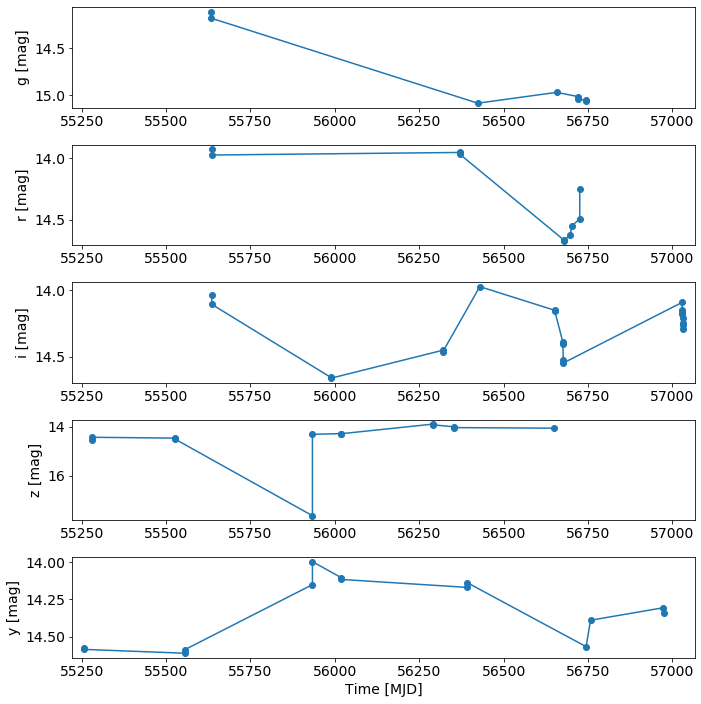

In [15]:
## para graficar, siendo una tabla de PS1
if 'curve_ps1' in catalog_hms:
    dtab_pan = table_ps1 # la tabla en astropy, de un elemento
    id2filter = np.array(list('grizy'))
    dtab_pan['filter'] = id2filter[(dtab_pan['filterID']-1).data]
    dtab_pan.sort('obsTime')
    
    # convert flux in Jy to magnitudes
    t = dtab_pan['obsTime']
    mag = -2.5*np.log10(dtab_pan['psfFlux']) + 8.90
    xlim = np.array([t.min(),t.max()])
    xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])

    pylab.rcParams.update({'font.size': 14})
    pylab.figure(1,(10,10))
    for i, filter in enumerate("grizy"):
        pylab.subplot(511+i)
        w = np.where(dtab_pan['filter']==filter)
        pylab.plot(t[w],mag[w],'-o')
        pylab.ylabel(filter+' [mag]')
        pylab.xlim(xlim)
        pylab.gca().invert_yaxis()
    # if i==0:
       # pylab.title(objname)
    pylab.xlabel('Time [MJD]')
    pylab.tight_layout()
    #print(dtab)

In [16]:
tabla_ztf = ascii.read(rdg.json()['curve_ztf']['841108100002803'],  format='csv', guess=False)
print(tabla_ztf.columns)
tabla_ztf['filtercode','field','limitmag','magzp']

<TableColumns names=('oid','expid','hjd','mjd','mag','magerr','catflags','filtercode','ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp','magzprms','clrcoeff','clrcounc','exptime','airmass','programid')>


filtercode,field,limitmag,magzp
str2,int64,float64,float64
zg,841,19.9699993,26.2987614
zg,841,20.0,26.3244419
zg,841,20.0699997,26.1978493
zg,841,19.8500004,25.9768658
zg,841,20.3799992,26.1693344
zg,841,20.4799995,26.1755791
zg,841,21.2700005,26.2607956
zg,841,20.2999992,26.2822933
zg,841,20.2199993,26.0177231


In [ ]:
'mag{}'.format(tabla['filtercode'][0])

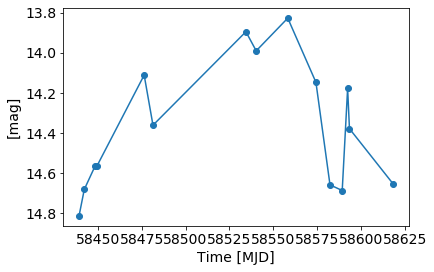

In [17]:
# Para graficar desde una tabla proveniente de ZTF
#
# En construccion
#
if 'curve_ztf' in catalog:
    dtab_ztf = tabla # la respectiva tabla de ztf
    dtab_ztf.sort('mjd')
    
    t = dtab_ztf['mjd']
    #magtag = 'mag{}'.format(tabla['filtercode'][0])
    #mag = dtab_ztf[magtag]
    pylab.rcParams.update({'font.size': 14})
    #pylab.figure(1,(10,10))
    
    pylab.plot(dtab_ztf['mjd'],dtab_ztf['mag'],'-o')
    pylab.ylabel('[mag]')
    #pylab.xlim(xlim)
    pylab.gca().invert_yaxis()
    
    pylab.xlabel('Time [MJD]')
    pylab.tight_layout()
    

In [ ]:
np.array(list('grizy'))